Ablation with the additional context 

```
Bellow is a question from the American Community Survey.
```

In [1]:
base_dir = '../results/'
dir_individual = base_dir + 'ablation/'
census_file = base_dir + 'pums_2019.csv'
ablation = 'c0'

import sys; sys.path.insert(0,'../')

In [2]:
import os
from tqdm import tqdm

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from plot_utils.models import hf_models, openai_models, model_names, instruct, model_sizes

all_models = sorted(hf_models, key=lambda x: model_sizes[x])
base_models = sorted(list(set(all_models) - set(instruct.keys())), key=lambda x: model_sizes[x])
instruction_models = sorted(list(set(instruct.keys()).intersection(set(all_models))), key=lambda x: model_sizes[x])

# due to space constrains, do not plot gptneo2.7b and llama since similar models were evaluated
plot_models = list(set(base_models) - set(['gptneo2.7b', 'llama7b', 'llama13b', 'llama65b']))
plot_models = sorted(plot_models, key=lambda x: model_sizes[x])

### Load responses

In [4]:
from plot_utils.plot_utils import acs_categories as n_categories
from plot_utils.plot_utils import load_acs_census_responses
from surveying_llms.load_responses import load_naive_responses, load_adjusted_responses

variables = list(n_categories.keys())
uniform_responses = {var: np.ones(n_categories[var]) / n_categories[var] for var in variables}
census_responses = load_acs_census_responses(census_file, n_categories)
choice_responses, adjusted_responses, naive_responses = load_adjusted_responses(
    dir_individual, all_models, n_categories, openai_models, ablation=ablation, return_naive=True
)

Loading adjusted responses...


100%|██████████| 29/29 [00:02<00:00, 12.25it/s]


In [5]:
from plot_utils.plot_utils import compute_entropy, compute_kl

uniform_entropies = {var: compute_entropy(uniform_responses[var]) for var in variables}
census_norm_entropies = {v: compute_entropy(census_responses[v]) / uniform_entropies[v] for v in variables}
naive_norm_entropies = {v: {m: compute_entropy(naive_responses[v][m]) / uniform_entropies[v] 
                            for m in base_models} for v in variables}
adjusted_norm_entropies = {v: {m: compute_entropy(adjusted_responses[v][m]) / uniform_entropies[v] 
                            for m in all_models} for v in variables}


kl_uniform_census = {v: compute_kl(uniform_responses[v], census_responses[v]) for v in variables}
naive_kl_census = {v: {m: compute_kl(naive_responses[v][m], census_responses[v])
                   for m in base_models} for v in variables}
kl_unadj_census = {v: {m: compute_kl(naive_responses[v][m], census_responses[v])
                   for m in base_models} for v in variables}
adjusted_kl_census = {v: {m: compute_kl(adjusted_responses[v][m], census_responses[v])
                   for m in all_models} for v in variables}
adjusted_kl_uniform = {v: {m: compute_kl(adjusted_responses[v][m], uniform_responses[v])
                   for m in all_models} for v in variables}

### Figures 1

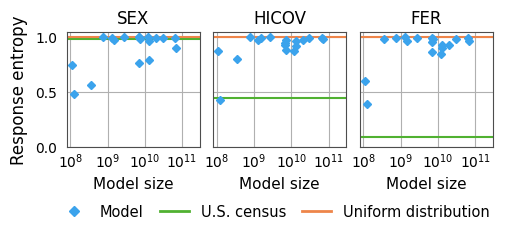

In [6]:
from plot_utils.plot_utils import figure_1
figure_1(naive_norm_entropies, census_norm_entropies, base_models, model_sizes)
plt.show()

### Figure 2b

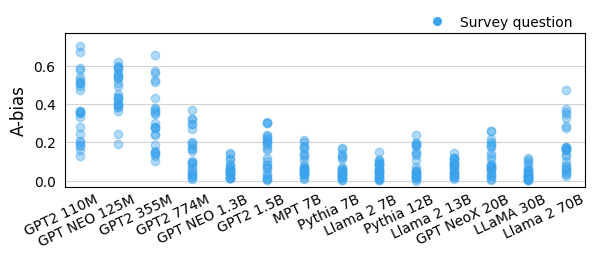

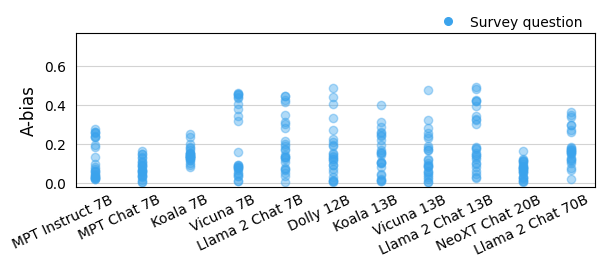

In [7]:
from plot_utils.plot_utils import plot_a_bias
a_bias = {m: [abs(choice_responses[v][m][0] - (1. / n_categories[v])) for v in variables] for m in all_models}
plot_a_bias(a_bias, plot_models, model_names, figsize=(6.7, 2))
plt.ylim([None, 0.77])
plt.show()

a_bias = {m: [abs(choice_responses[v][m][0] - (1. / n_categories[v])) for v in variables] for m in all_models}
plot_a_bias(a_bias, instruction_models, model_names, figsize=(6.7, 2))
plt.ylim([None, 0.77])
plt.show()

### Figure 2a, 3a, 3b

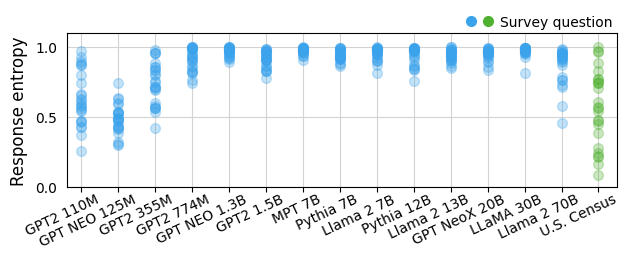

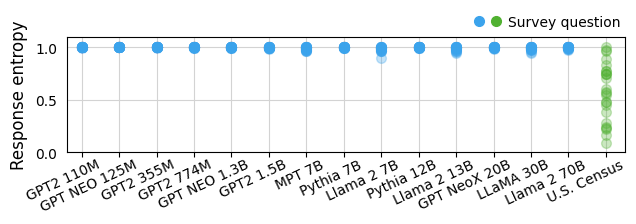

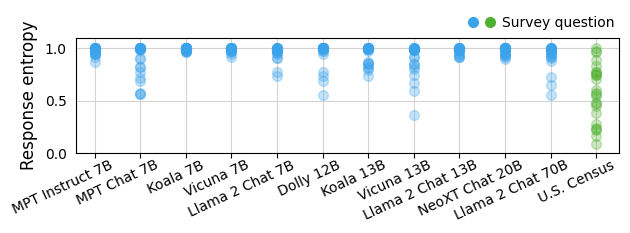

In [8]:
from plot_utils.plot_utils import plot_adjusted_entropy

plot_adjusted_entropy(naive_norm_entropies, census_norm_entropies, 
                      plot_models, variables, model_names, figsize=(7.1, 2), alpha=0.3)
plt.show()

plot_adjusted_entropy(adjusted_norm_entropies, census_norm_entropies, 
                      plot_models, variables, model_names, figsize=(7.2, 1.5), ylegend=1.3, alpha=0.3)
plt.show()

plot_adjusted_entropy(adjusted_norm_entropies, census_norm_entropies, 
                      instruction_models, variables, model_names, figsize=(7, 1.5), ylegend=1.3, alpha=0.3)
plt.show()

In [9]:
frac = {m: 0 for m in all_models}
for m in all_models:
    for v in variables:
        if adjusted_kl_uniform[v][m] >= adjusted_kl_census[v][m]:
            frac[m] += 1
frac = {k: v / len(variables) for k, v in frac.items()}
print('Largest fraction of questions closer to census than to uniform: %.2f' % (max(frac.values())))

Largest fraction of questions closer to census than to uniform: 0.12


### Figure 4a, 4b

In [10]:
from plot_utils.plot_utils import load_acs_state_responses
states, responses_states = load_acs_state_responses(census_file, n_categories)

# calculate divergence between adjusted responses and each state
subgroup_kls = {}
subgroup_kls_unadj = {}
for m in all_models:
    subgroup_kls[m] = {s: {v: compute_kl(adjusted_responses[v][m], responses_states[v][s]) 
                           for v in variables} for s in states}
    subgroup_kls_unadj[m] = {s: {v: compute_kl(naive_responses[v][m], responses_states[v][s]) 
                           for v in variables} for s in states}
    
# Do not consider ESR and JWTRNS since they contain choices with zero frequency for some of the states
variables_used = list(set(variables) - {'ESR', 'JWTRNS'})
divergence = {m: {s: np.mean([subgroup_kls[m][s][v] for v in variables_used])
                  for s in states} for m in all_models}
divergence_uniform = {m: np.mean([compute_kl(adjusted_responses[v][m], uniform_responses[v])
                                  for v in variables_used]) for m in all_models}
divergence_unadj =  {m: {s: np.mean([subgroup_kls_unadj[m][s][v] for v in variables_used])
                  for s in states} for m in all_models}

divergence_census = {m: np.mean([adjusted_kl_census[v][m] for v in variables_used]) for m in all_models}
subgroup_ent = {s: np.mean([compute_entropy(responses_states[v][s]) /  uniform_entropies[v] 
                          for v in variables]) for s in states}

Loading ACS responses by state...


100%|██████████| 50/50 [00:02<00:00, 18.06it/s]
/Users/rdo/Desktop/surveying-language-models 3/prompt-ablations/../plot_utils/plot_utils.py:41: RuntimeWarning: divide by zero encountered in divide
  return np.sum(pnz * np.log2(pnz / qnz))


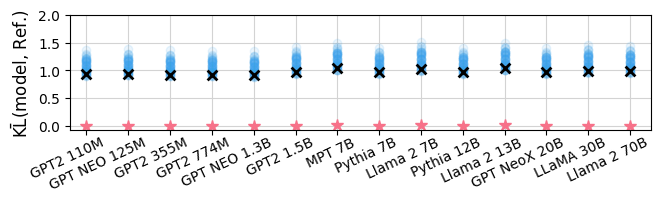

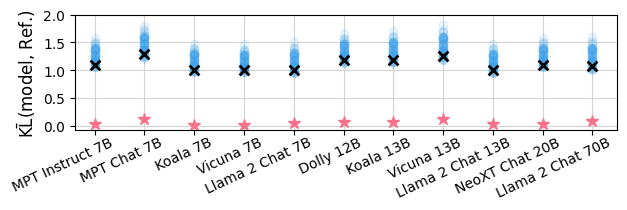

In [11]:
from plot_utils.plot_utils import plot_divergence_subgroups

plot_divergence_subgroups(divergence, divergence_uniform, divergence_census, plot_models, model_names, 
                          figsize=(7.5, 1.5))
plt.show()

plot_divergence_subgroups(divergence, divergence_uniform, divergence_census, instruction_models, model_names, 
                          figsize=(7, 1.5))
plt.show()

### Figure 5

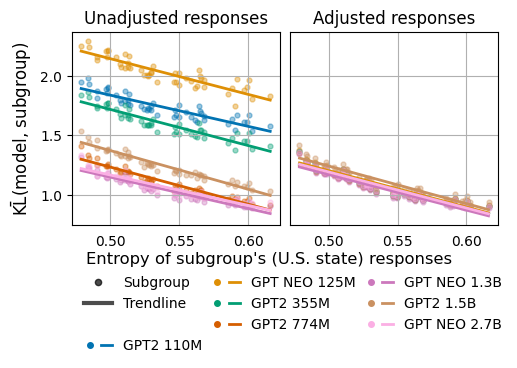

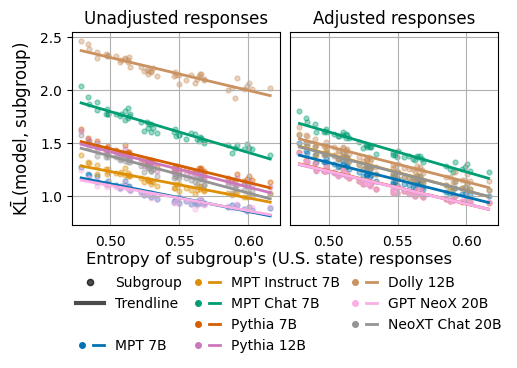

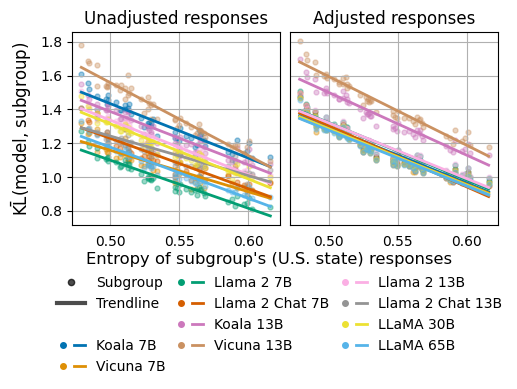

In [12]:
from plot_utils.plot_utils import plot_similarity_opinions

models_2_saves = {
    'plots/lin-trend-gpt2.pdf': ['gpt2', 'gptneo125m', 'gpt2m', 'gpt2l',
                                 'gptneo1.3b', 'gpt2xl', 'gptneo2.7b'],
    'plots/lin-trend-misc.pdf': ['mpt', 'mpt-instruct', 'mpt-chat',
                                 'pythia7', 'pythia12', 'dolly12b',
                                 'gptneox', 'gptneoxchat'],
    'plots/lin-trend-llama.pdf': ['koala7b', 'vicuna7b',
                                  'llama2-7b', 'llama2-7b-chat',
                                  'koala13b', 'vicuna13b',
                                  'llama2-13b', 'llama2-13b-chat',
                                  'llama30b', 'llama65b',
                                  'llama2-70b', 'llama2-70b-chat']
}

for save_name, save_models in models_2_saves.items():
    plot_similarity_opinions(states, divergence_unadj, divergence, subgroup_ent, save_models, model_names)
    plt.show()